mark

In [1]:
N = 56

input_shape = (N, N, 1)#datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

from xrdc import fourier

/home/ollie/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.signal import fft

from tensorflow.keras.layers import Lambda
from tensorflow.signal import fft, fft2d, fftshift, ifft2d, ifft2d

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# from skimage.transform import resize

from xrdc.source_separation import *
from skimage.transform import resize as sresize
from tensorflow.signal import fft2d, fftshift

    
padx = pady = N // 2
def do_resize():
    #padx = pady = x.shape[1] // 2
    transform = tfkl.AveragePooling2D(2)
    return tfk.Sequential([
        tfk.Input(shape = (N, N, 1)),
        transform
    ])

filt = fourier.lowpass_g(.1, np.ones(N))
probe = (np.einsum('i,j->ij', filt, filt))
tprobe = tf.convert_to_tensor(probe, dtype = 'complex64')

# def do_forward():
#     sequential = do_resize()
#     sequential.add(Lambda(lambda resized: tprobe * (fft2d(
#         tf.squeeze(tf.cast(resized, tf.complex64))
#     ))))
#     sequential.add(Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2))
#     sequential.add(Lambda(lambda psd: 
#                           tf.expand_dims(
#                               tf.math.sqrt(
#             fftshift(psd, (-2, -1))
#                                    ), 3)))
#     return sequential


def do_forward(sequential = None):
    """
    zero-pad the real-space object and then fourier transform it
    """
    if sequential is None:
        sequential = tfk.Sequential([])
        
    padder = tfkl.ZeroPadding2D((padx // 2, padx // 2))

    sequential.add(padder)
    sequential.add(tfk.Input(shape = (N, N, 1)))
    sequential.add(Lambda(lambda resized: tprobe * (fft2d(
        tf.squeeze(tf.cast(resized, tf.complex64))
    ))))
    sequential.add(Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2))
    sequential.add(Lambda(lambda psd: 
                          tf.expand_dims(
                              tf.math.sqrt(
            fftshift(psd, (-2, -1))
                                   ), 3)))
    return sequential


# def do_forward():
#     sequential = tfk.Sequential([tfkl.ZeroPadding2D((padx // 2, padx // 2))])
#     sequential.add(Lambda(lambda resized: (fft2d(
#         tf.squeeze(tf.cast(resized, tf.complex64))
#     ))))
#     sequential.add(Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2))
#     sequential.add(Lambda(lambda psd: 
#                           tf.expand_dims(
#                               tf.math.sqrt(
#             fftshift(psd, (-2, -1))
#                                    ), 3)))
#     return sequential


@tf.function
def get_mask(input):
    import tensorflow as tf
    mask = tf.where(input >= support_threshold, tf.ones_like(input),
                    tf.zeros_like(input))
    return mask

@tf.function
def add_support(input):
    mask = get_mask(input)
    return input * tf.cast(mask, tf.float32)

def resize(x):
    rmod = do_resize()
    rmod.compile(loss = 'mse')
    return rmod.predict(x)

rmod = do_forward()
rmod.compile(loss='mse')
#rmod.fit(x)

2022-09-29 16:40:52.591814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 16:40:52.860703: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-29 16:40:53.467971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2022-09-29 16:40:53.468332: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

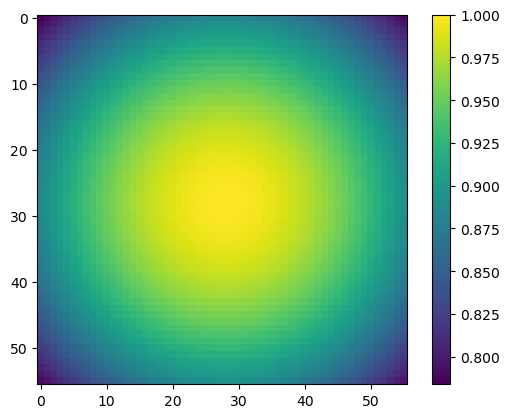

In [3]:
plt.imshow(probe)
plt.colorbar()

In [4]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.get_memory_usage('GPU:0')

Instructions for updating:
Use tf.config.experimental.get_memory_info(device)['current'] instead.


27648

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
from xrdc import fourier

In [8]:
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print(cuda_version)

11.2


In [9]:
cudnn_version = sys_details["cudnn_version"]  
print(cudnn_version)

8


In [11]:
%pdb

Automatic pdb calling has been turned OFF


In [12]:
datasets2, datasets_info2 = tfds.load(name='div2k',
                                    with_info=True,
                                    as_supervised=False)

In [44]:
def split_image(image3, tile_size):
    n, m =  image3.shape[0], image3.shape[1]
    N, M = (n // tile_size[0]) * tile_size[0], (m // tile_size[1]) * tile_size[1]
    image3 = image3[:N, :M, :]
    image_shape = tf.shape(image3)
    tile_rows = tf.reshape(image3, [image_shape[0], -1, tile_size[1], image_shape[2]])
    serial_tiles = tf.transpose(tile_rows, [1, 0, 2, 3])
    return tf.reshape(serial_tiles, [-1, tile_size[1], tile_size[0], image_shape[2]])

def split_tf_image(img):
    return split_image(img['hr'], [N, N])[:, :, :, 0]

def img_get(key):
    foo =  iter(datasets2[key])
    for _ in range(20):
        yield split_tf_image(next(foo))

In [61]:
def mk_ds_slices(key):
    tmp = list(img_get(key))
    tmp = tf.concat(tmp, 0)
    tmp2 = tf.data.Dataset.from_tensor_slices(tmp)
    return tmp2

In [62]:
ds = mk_ds_slices('train')

In [63]:
DATASET_SIZE = len(ds)

train_size = int(0.6 * DATASET_SIZE)
# val_size = int(0.4 * DATASET_SIZE)
test_size = int(0.4 * DATASET_SIZE)

full_dataset = ds#tf.data.TFRecordDataset(FLAGS.input_file)
full_dataset = full_dataset.shuffle(int(10e3))
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [58]:
next(iter(ds)).shape

TensorShape([56, 56])

In [54]:
plt.imshow(next(iter(ds)) * tf.convert_to_tensor(probe), cmap = 'Greys')

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a uint8 tensor but is a double tensor [Op:Mul]

In [60]:
next(iter(ds))

<tf.Tensor: shape=(56, 56), dtype=uint8, numpy=
array([[128, 112, 107, ...,  30, 124,  93],
       [ 74,  99, 141, ...,  91,  83, 136],
       [164,  99,  65, ..., 117,  55, 103],
       ...,
       [167, 153, 151, ..., 162, 157, 107],
       [170, 172, 170, ..., 111,  79, 125],
       [168, 167, 168, ...,  86, 127, 170]], dtype=uint8)>

In [64]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)


# def _preprocess(sample):
#     image = tf.cast(tf.image.resize(sample['image'], [N, N]), 
#                     tf.float32) / 255.  # Scale to unit interval.
#     rmod = do_forward(do_resize())
#     rmod.compile(loss='mse')
#     orig = tf.identity(image)
#     image = rmod(image)#rmod.predict(image)
#     return image, image, orig

def _preprocess(sample):
    image = tf.cast(sample, 
                    tf.float32) / 255.  # Scale to unit interval.
    rmod = do_forward()
    #rmod = do_forward(do_resize())
    rmod.compile(loss='mse')
    orig = tf.identity(image)
    image = rmod(image)#rmod.predict(image)
    return image, image, orig

# train_dataset = (datasets['train']
#                  .batch(256)
#                  .map(_preprocess)
#                  .cache()
#                  .prefetch(tf.data.AUTOTUNE)
#                  .shuffle(int(10e3)))


# eval_dataset = (datasets['test']
#                 .batch(256)
#                 .map(_preprocess)
#                 .cache()
#                 .prefetch(tf.data.AUTOTUNE))

train_dataset = (train_dataset
                 .batch(256)
                 .map(_preprocess)
                 .cache()
                 .prefetch(tf.data.AUTOTUNE)
                 .shuffle(int(10e3)))


eval_dataset = (test_dataset
                .batch(256)
                .map(_preprocess)
                .cache()
                .prefetch(tf.data.AUTOTUNE))

ValueError: in user code:

    File "/tmp/ipykernel_34805/781457519.py", line 22, in _preprocess  *
        image = rmod(image)#rmod.predict(image)
    File "/home/ollie/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/ollie/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential" "                 f"(type Sequential).
    
    Input 0 of layer "zero_padding2d" is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: (None, 56, 56)
    
    Call arguments received by layer "sequential" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 56, 56), dtype=float32)
      • training=None
      • mask=None


In [97]:
x = next(iter(eval_dataset))[0][:10]

2022-09-28 16:49:53.283128: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-28 16:49:53.344987: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [98]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [99]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tf.keras.layers.BatchNormalization(),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])


In [100]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tf.keras.layers.BatchNormalization(),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    
#     tfkl.Conv2DTranspose(base_depth, 5, strides=2,
#                          padding='same', activation=tf.nn.leaky_relu),
#     tfkl.Conv2DTranspose(base_depth, 5, strides=1,
#                          padding='same', activation=tf.nn.leaky_relu),
    

    tf.keras.layers.BatchNormalization(),
#     tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
#                 padding='same', activation=None),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=tf.nn.sigmoid),
    
#      tfkl.Reshape((input_shape)),
   tfkl.Reshape((input_shape[0] // 2, input_shape[1] // 2, 1)),

##     Lambda(lambda x: tf.clip_by_value(x, 0, 1))
    
    # impose real space support
#     Lambda(lambda x: add_support(x),
#                     name='masked_obj')
    
])

support_threshold = .2


decoder2 = tfk.Sequential([
    tfkl.InputLayer(input_shape = tf.TensorShape([None, None, None])),
    do_forward(),
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc = t, scale = 0.0015))),
])


In [101]:
# vae = tfk.Model(inputs=encoder.inputs,
#                 outputs=decoder(encoder.outputs[0]))

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder2(decoder(encoder.outputs[0])))

In [102]:
for layer in decoder.layers:
    print(layer.name, layer.output_shape)

reshape_2 (None, 1, 1, 16)
batch_normalization_4 (None, 1, 1, 16)
conv2d_transpose_6 (None, 7, 7, 64)
conv2d_transpose_7 (None, 7, 7, 64)
conv2d_transpose_8 (None, 14, 14, 64)
conv2d_transpose_9 (None, 14, 14, 32)
conv2d_transpose_10 (None, 28, 28, 32)
conv2d_transpose_11 (None, 28, 28, 32)
batch_normalization_5 (None, 28, 28, 32)
conv2d_11 (None, 28, 28, 1)
reshape_3 (None, 28, 28, 1)


In [103]:
for layer in decoder2.layers:
    print(layer.name, layer.output_shape)

sequential_8 None
distribution_lambda_1 (None, None)


In [106]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negloglik)

In [111]:
_ = vae.fit(train_dataset,
            epochs=5,
            validation_data=eval_dataset)

Epoch 1/5
235/235 [==============================] - ETA: 0s - loss: 41014.4766

235/235 [==============================] - 11s 46ms/step - loss: 41014.4766 - val_loss: 41428.7539
Epoch 2/5
235/235 [==============================] - ETA: 0s - loss: 40586.0430

235/235 [==============================] - 11s 45ms/step - loss: 40586.0430 - val_loss: 41089.5938
Epoch 3/5
235/235 [==============================] - ETA: 0s - loss: 39918.6172

235/235 [==============================] - 11s 46ms/step - loss: 39918.6172 - val_loss: 39701.3828
Epoch 4/5
235/235 [==============================] - ETA: 0s - loss: 39403.8789

235/235 [==============================] - 11s 46ms/step - loss: 39403.8789 - val_loss: 40083.9414
Epoch 5/5
235/235 [==============================] - ETA: 0s - loss: 38883.3398

235/235 [==============================] - 11s 45ms/step - loss: 38883.3398 - val_loss: 39848.3086


In [18]:
# !pip install pydot

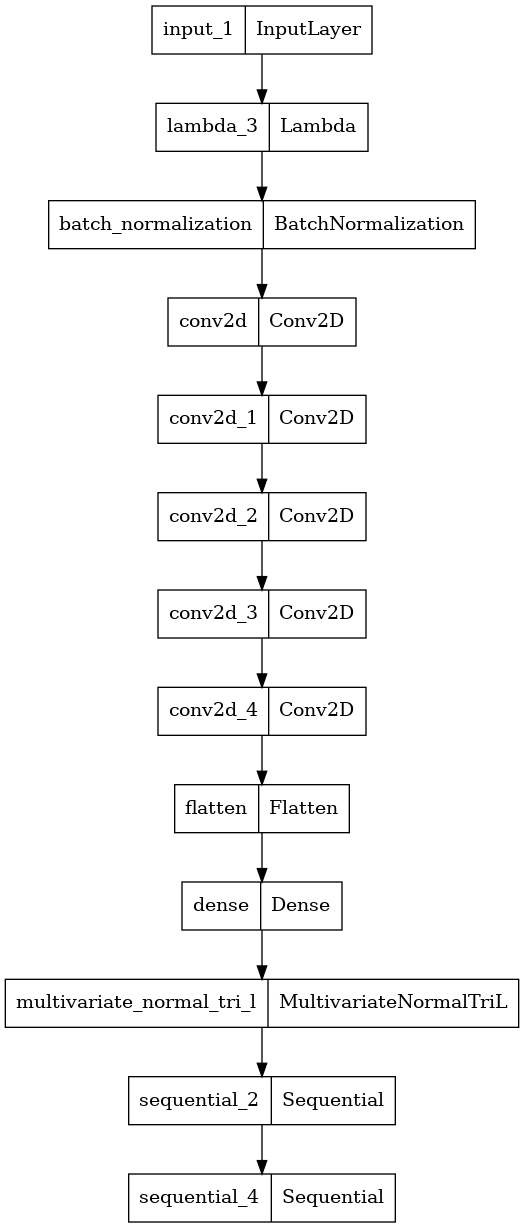

In [23]:
tf.keras.utils.plot_model(vae, 'foo.png')

In [108]:
import matplotlib.pyplot as plt

def display_imgs(x, y=None, log = True, cbar = False):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  #plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 2))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    if log:
        axs.flat[i].imshow(np.log(.01 + x[i].squeeze()), interpolation='none', cmap='jet')
    else:
        axs.flat[i].imshow((x[i].squeeze()), interpolation='none', cmap='jet')
    axs.flat[i].axis('off')
  if cbar:
    plt.colorbar()
  plt.show()
  plt.close()
  plt.ion()

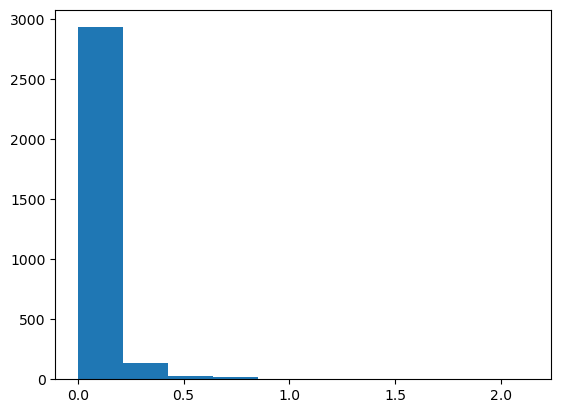

In [109]:
plt.hist(np.array(tf.squeeze(x[5])).ravel());

In [67]:
# plt.imshow(np.array((decoder(encoder(x)))).squeeze()[4], cmap = 'jet')

# plt.imshow(np.array(resize((x_orig))).squeeze()[2], cmap = 'jet')

# plt.imshow(np.array(resize(decoder(encoder(x)))).squeeze()[2], cmap = 'jet')

In [68]:
# plt.imshow(np.array(decoder2(decoder(encoder(x))).mean()).squeeze()[0], cmap = 'jet')

In [26]:
from xrdc import fourier

Input diffraction:


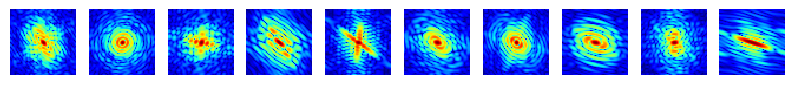

Reconstructed diffraction (modes):


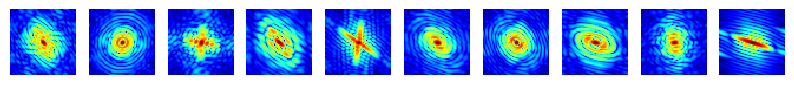

True object


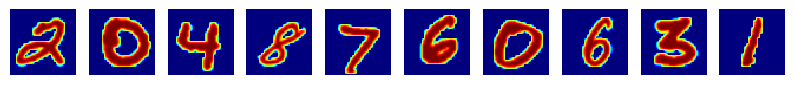

Reconstructed object (mode)


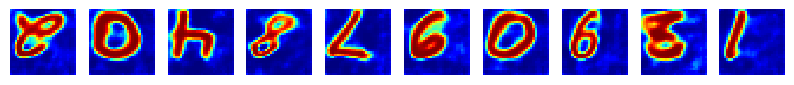

Reconstructed object variance


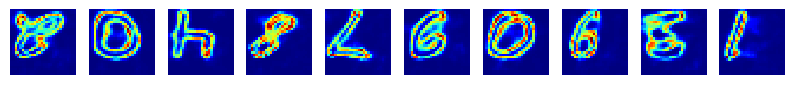

Reconstructed diffraction variance


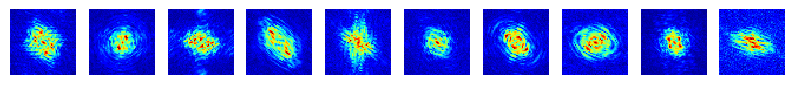

0.013367399062030159

In [112]:
x_orig = next(iter(eval_dataset))[2][:10]

# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]

# x_orig = next(iter(eval_dataset))[2][10:20]

# # We'll just examine ten random digits.
# x = next(iter(eval_dataset))[0][10:20]

xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 20)

print('Input diffraction:')
display_imgs(x)

# print('Decoded Random Samples (top: reconstruction; bottom: diffraction):')
# tmp = decoder(encoder(x))
# display_imgs(tmp)
# display_imgs(decoder2(tmp).sample())

print('Reconstructed diffraction (modes):')
display_imgs(xhat.mode())

# print('Decoded Means:')
# display_imgs(xhat.mean())

print("True object")
display_imgs((x_orig))

print("Reconstructed object (mode)")
display_imgs((decoder(encoder(x).mode())))

print('Reconstructed object variance')
tmp = tf.stack([decoder(encoder(x)) for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))

print('Reconstructed diffraction variance')
tmp = tf.stack([vae(x).sample() for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))


# display_imgs(tf.abs(decoder(encoder(x).mode()) - resize(x_orig)))

np.percentile(np.array(tmp).std(axis = 0).ravel(), 99.9)



Randomly Generated Samples:


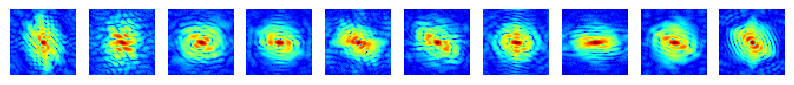

Randomly Generated Modes:


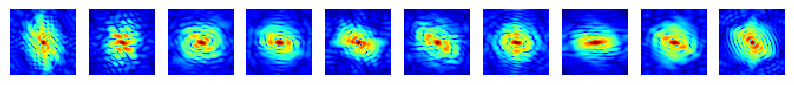

Randomly Generated Means:


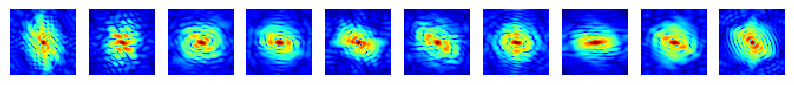

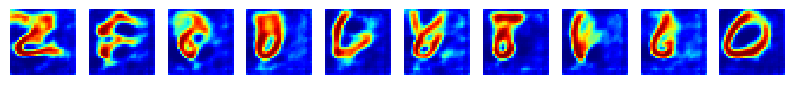

In [119]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder2(decoder(z))
assert isinstance(xtilde, tfd.Distribution)

print('Randomly Generated Samples:')
samp = xtilde.sample()
display_imgs(samp)

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

display_imgs((decoder(z)))

#display_imgs((decoder(encoder(samp))))

Illuminated object
1/1 [==============================] - 0s 38ms/step


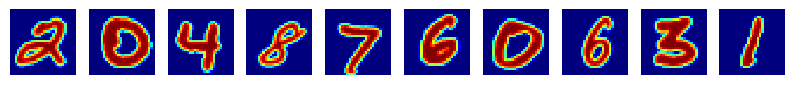

In [113]:
print("Illuminated object")
display_imgs(resize((x_orig) * 
                    tf.convert_to_tensor(probe, dtype= 'float')[:, :, None]
                   )
            )

Input diffraction:


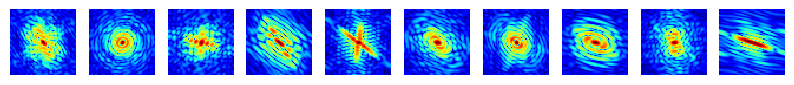

Reconstructed diffraction (modes):


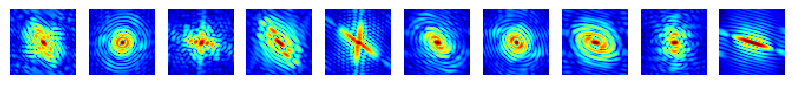

True object


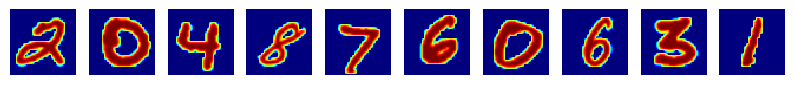

Reconstructed object (mode)


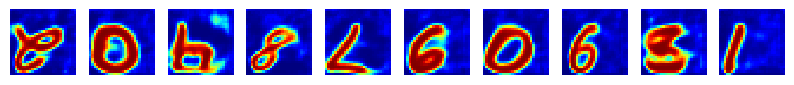

Reconstructed object variance


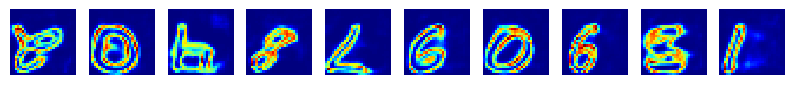

Reconstructed diffraction variance


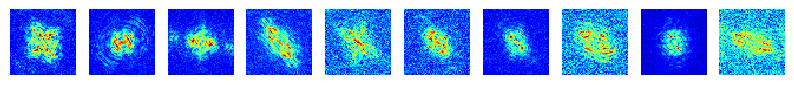

0.009230946562252979

In [222]:
x_orig = next(iter(eval_dataset))[2][:10]

# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]

# x_orig = next(iter(eval_dataset))[2][10:20]

# # We'll just examine ten random digits.
# x = next(iter(eval_dataset))[0][10:20]

xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 20)

print('Input diffraction:')
display_imgs(x)

# print('Decoded Random Samples (top: reconstruction; bottom: diffraction):')
# tmp = decoder(encoder(x))
# display_imgs(tmp)
# display_imgs(decoder2(tmp).sample())

print('Reconstructed diffraction (modes):')
display_imgs(xhat.mode())

# print('Decoded Means:')
# display_imgs(xhat.mean())

print("True object")
display_imgs((x_orig))

print("Reconstructed object (mode)")
display_imgs((decoder(encoder(x).mode())))

print('Reconstructed object variance')
tmp = tf.stack([decoder(encoder(x)) for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))

print('Reconstructed diffraction variance')
tmp = tf.stack([vae(x).sample() for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))


# display_imgs(tf.abs(decoder(encoder(x).mode()) - resize(x_orig)))

np.percentile(np.array(tmp).std(axis = 0).ravel(), 99.9)



In [230]:
np.array(tmp).mean(axis = 0).mean(axis = 3).mean(axis = 2).mean(axis = 1)

array([0.04129243, 0.04187356, 0.03157837, 0.03132818, 0.03076614,
       0.03673065, 0.03975851, 0.03492882, 0.03467346, 0.02339565],
      dtype=float32)

Illuminated object
1/1 [==============================] - 0s 20ms/step


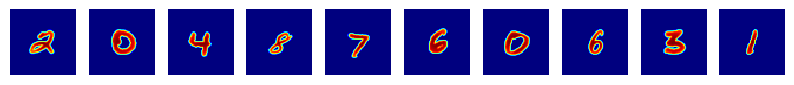

In [71]:
print("Illuminated object")
display_imgs(resize((x_orig) * 
                    tf.convert_to_tensor(probe, dtype= 'float')[:, :, None]
                   )
            )

Diffraction:


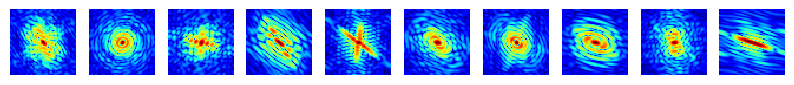

Decoded Random Samples:


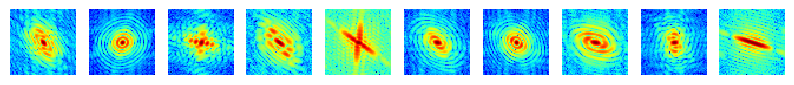

Decoded Modes:


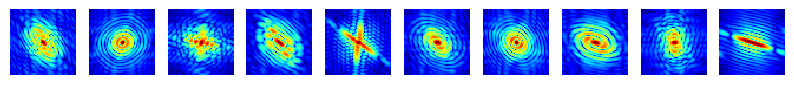

Decoded Means:


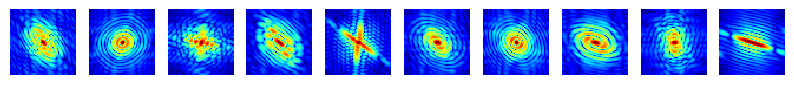

True object
1/1 [==============================] - 0s 20ms/step


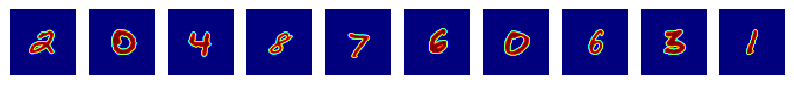

Reconstructed object
1/1 [==============================] - 0s 20ms/step


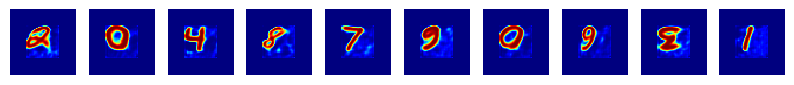

Variance


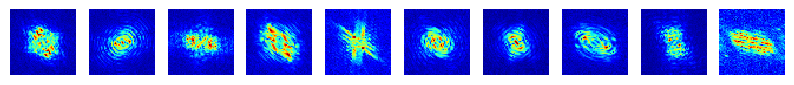

0.0034961721

In [436]:
x_orig = next(iter(eval_dataset))[2][:10]

# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 20)

print('Diffraction:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

print("True object")
display_imgs(resize(x_orig))

print("Reconstructed object")
display_imgs(resize(decoder(encoder(x).mode())))

print('Variance')
tmp = tf.stack([vae(x).sample() for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))
np.array(tmp).std(axis = 0).mean()

Illuminated object
1/1 [==============================] - 0s 21ms/step


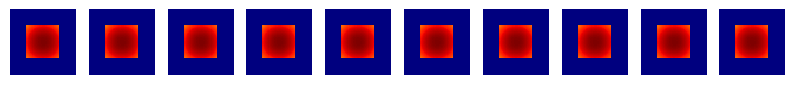

In [434]:
print("Illuminated object")
display_imgs(resize(tf.ones_like(x_orig) * 
                    tf.convert_to_tensor(probe, dtype= 'float')[:, :, None]
                   )
            )

In [360]:
# mkdir models/mnist_fourier_vae/

In [232]:
vae.save('models/mnist_fourier_vae/vae.h5')

encoder.save('models/mnist_fourier_vae/encoder.h5')

decoder.save('models/mnist_fourier_vae/decoder.h5')

decoder2.save('models/mnist_fourier_vae/decoder2.h5')

Randomly Generated Samples:


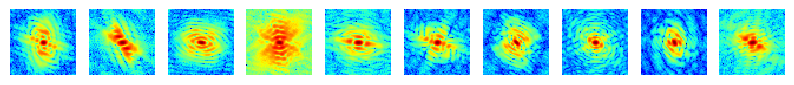

Randomly Generated Modes:


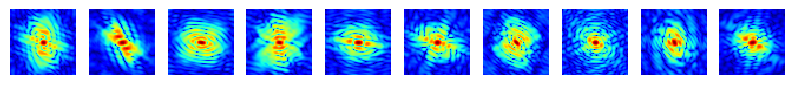

Randomly Generated Means:


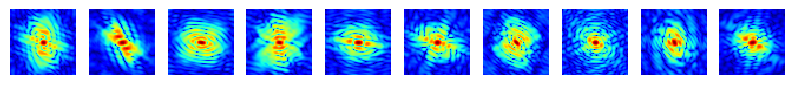

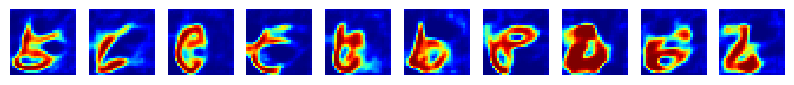

In [255]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder2(decoder(z))
assert isinstance(xtilde, tfd.Distribution)

print('Randomly Generated Samples:')
samp = xtilde.sample()
display_imgs(samp)

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

display_imgs((decoder(z)))

#display_imgs((decoder(encoder(samp))))

Randomly Generated Samples:


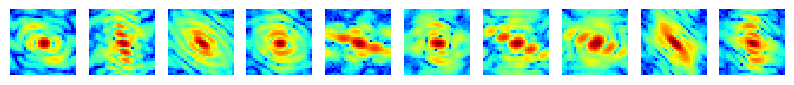

Randomly Generated Modes:


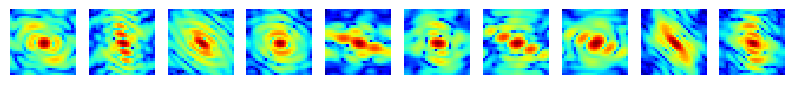

Randomly Generated Means:


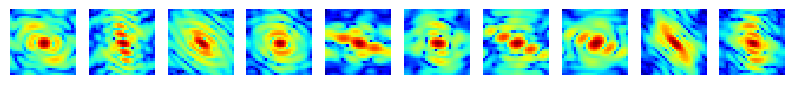

1/1 [==============================] - 0s 20ms/step


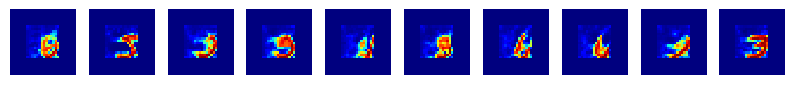

1/1 [==============================] - 0s 20ms/step


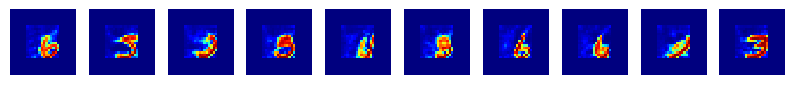

In [23]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder2(decoder(z))
assert isinstance(xtilde, tfd.Distribution)

print('Randomly Generated Samples:')
samp = xtilde.sample()
display_imgs(samp)

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

display_imgs(resize(decoder(z)))

display_imgs(resize(decoder(encoder(samp))))

Randomly Generated Samples:


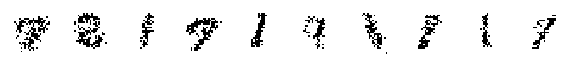

Randomly Generated Modes:


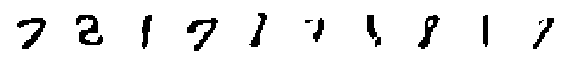

Randomly Generated Means:


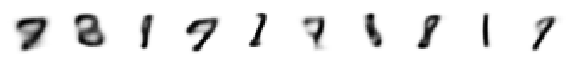

In [455]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

In [522]:
import os

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [523]:
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [542]:
do_forward(nn.ZeroPad2d((0, 1, 0, 1))(x)).shape

torch.Size([16, 1, 29, 29])

In [543]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.Compose([transforms.ToTensor(),
                                nn.ZeroPad2d((0, 1, 0, 1)),
                                do_forward])
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [544]:
import torchvision

In [586]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, N**2)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
        self.z_dim = z_dim
        
        base_depth = 32
        
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(1, 2 * base_depth, 7, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU()
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU())
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=2, padding='same'),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU()
        )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(base_depth, base_depth, kernel_size=5, stride=2, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer6 = nn.Sequential(
            nn.ConvTranspose2d(base_depth, base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(base_depth, 1, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth)  
    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output distribution
        # each is of size batch_size x (flattened data size)
        loc_img = self.sigmoid(self.fc21(hidden)).reshape(-1, N, N)
        blur = torchvision.transforms.GaussianBlur(5, sigma=(.8, .8))

        return blur(loc_img)

In [587]:
import torch.nn.functional as F

In [588]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim = 7*7*16):
        super().__init__()
        
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #self.fc1 = nn.Linear(7*7*32, hidden_dim)

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, base_depth, kernel_size=5, stride=1, padding='same'),
#             nn.BatchNorm2d(base_depth),
#             nn.LeakyReLU()
#         )
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(base_depth, base_depth, kernel_size=5, stride=2, padding='same'),
#             nn.BatchNorm2d(base_depth),
#             nn.LeakyReLU())
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(base_depth, 2 * base_depth, kernel_size=5, stride=1, padding='same'),
#             nn.BatchNorm2d(2 * base_depth),
#             nn.LeakyReLU()
#         )
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=2, padding='same'),
#             nn.BatchNorm2d(2 * base_depth),
#             nn.LeakyReLU())
        
        
        
        # setup the three linear transformations used
        #self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x


        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        #hidden = self.softplus(self.fc1(out))
        hidden = self.softplus(out)

#         # first shape the mini-batch to have pixels in the rightmost dimension
#         x = x.reshape(-1, 784)
        # then compute the hidden units
        #hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [589]:
obs_sigma = .05

In [591]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=7*7*16, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        #x = do_forward(x)
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z

            loc_img = do_forward(
                    self.decoder(z)
                ).reshape(-1, N**2)
            # score against actual images
            #pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
            return pyro.sample("obs", dist.Normal(loc_img, obs_sigma).to_event(1),
                               obs=x.reshape(-1, N**2))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        #x = do_forward(x)
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [592]:
do_forward(x[10]).max()

tensor(0.4922)

In [593]:
vae = VAE()

In [594]:
optimizer = Adam({"lr": 1.0e-3})

In [595]:
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [596]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [597]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test